In [11]:
import numpy as np
from numba import jit, vectorize, float64, prange
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [12]:
@jit(nopython = True)
def default_escape_cond(z_re, z_im):
    return (z_re * z_re + z_im * z_im >= 4)

def mandelbrot_point_factory(max_iter, escape_condition):
    @jit(nopython=True)
    def _mandelbrot(c_re, c_im):
        z_re, z_im = c_re, c_im
        for count in range(max_iter):
            z_re = z_re*z_re - z_im*z_im + c_re
            z_im = 2*z_re*z_im + c_im
            if (escape_condition(z_re, z_im)):
                return count
        return count
    
    return _mandelbrot

In [13]:
@jit(nopython = True, parallel = True, nogil = True)
def mandelbrot_mc(max_iter, samples_count, samples, iter_counts):
    """
    TODO: Add docstring
    """
    set_count = 0
    for i in prange(samples_count):
        c = samples[i]
        zn = c
        for j in range(1, max_iter):
            zn = zn*zn + c
            if (np.abs(zn) > 2):
                # numba should recognize this as a critical section
                iter_counts[i] = j
                break
            elif j == max_iter - 1:
                iter_counts[i] = j
                set_count += 1
    return set_count

@jit(nopython = True)
def mandelbrot_area(count, N, re_low, re_high, im_low, im_high):
    rect_area = (re_high - re_low) * (im_high - im_low)
    return rect_area * count / N

In [18]:
N = 10**6  # Full HD Mandelbrot set
i = 1000
re_low, re_high = -2., 1.
im_low, im_high = -1.5, 1.5
area = (re_high - re_low) * (im_high - im_low)
np.random.seed(2398475)
samples_re = np.random.uniform(low = re_low, high = re_high, size = N)
samples_im = np.random.uniform(low = im_low, high = im_high, size = N)
samples = samples_re + 1j*samples_im
iter_counts = np.zeros(N)

In [19]:
start_time = timer()
count = mandelbrot_mc(i, N, samples, iter_counts)
end_time = timer()
print(f"Execution time: {np.round(end_time - start_time, 2)} seconds")
print(mandelbrot_area(count, N, re_low, re_high, im_low, im_high))

Execution time: 0.36 seconds
1.512234


In [7]:
mandelbrot_indices = np.where(iter_counts == i-1)
mandelbrot_subset_re = samples_re[mandelbrot_indices]
mandelbrot_subset_im = samples_im[mandelbrot_indices]

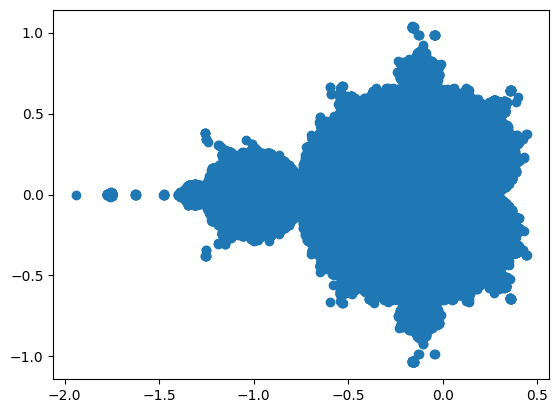

In [8]:
plt.scatter(mandelbrot_subset_re, mandelbrot_subset_im)
plt.show()

In [9]:
# [WARN]: On Linux Mint 20, 16GB RAM, 2GB swap space, the kernel crashes as it runs out of memory for N = 1.0e9
N = 10**8
np.random.seed(10010)
samples_re = np.random.uniform(low = re_low, high = re_high, size = N)
samples_im = np.random.uniform(low = im_low, high = im_high, size = N)
samples = samples_re + 1j*samples_im
iter_counts = np.zeros(N, dtype=np.int32)

In [49]:
start_time = timer()
count = mandelbrot_mc(i, N, samples, iter_counts)
end_time = timer()
print(end_time - start_time)
print(count / N * area)

9.812271489998238
1.5219909


In [32]:
print(count / N)

0.60970228
